# Spatiotemporal relationships between spatial accessibility to intensive care unit beds and mortality of COVID-19 in the state of Texas 

**Authors**: Jinwoo Park <sup>1,2</sup>, Alexander Michels<sup>1,2</sup>, Fangzheng Lyu<sup>1,2</sup>, Su Yeon Han<sup>1,2</sup>, and Shaowen Wang<sup>1,2,*</sup> <br>
<sup>1</sup> Department of Geography and Geographic Information Science, University of Illinois Urbana-Champaign <br>
<sup>2</sup> CyberGIS Center for Advanced Digital and Spatial Studies, University of Illinois Urbana-Champaign <br>
<sup>*</sup> Correspondence: Shaowen Wang, shaowen@illinois.edu <br>

Last Updated Date: May 26, 2022

### Abstract:
During the coronavirus disease 2019 (COVID-19) pandemic, many patients could not receive timely healthcare services due to limited access to hospital infrastructure and human resources. Previous research showed that sufficient access to healthcare resources, such as intensive care unit (ICU) beds and ventilators, is important to save lives. However, little attention has been paid to the underlying temporal dynamics of healthcare resource availability and COVID-19 cases. To fill this gap, our study aims to investigate the spatiotemporal relationships between spatial accessibility to ICU beds and the mortality of COVID-19, under the changes in ICU bed availability and COVID-19 confirmed cases. We first integrate the historical temporal changes of availability and confirmed cases to assess daily spatial accessibility to ICU beds with an enhanced two-step floating catchment area (E2SFCA) method. We then observe how insufficient accessibility to ICU beds and increased mortality are correlated with Kendall’s tau. As results, strong negative correlation coefficients were observed in the county-level analysis between sufficient accessibility to ICU beds and mortality of COVID-19. In addition, we found that populous counties in North, Southeast, and Central Texas showed a more substantial relationship than those in West Texas, which have sparse population density. Our study identified vulnerable areas where low spatial accessibility levels were highly related to deaths based on their retrospective relationship. We also suggested that extra resources might be necessary for big cities to adequately deal with the acute surge of patients, which could support policymakers in saving lives for future pandemic scenarios. 

### Keywords:
Spatial accessibility, COVID-19, Healthcare resources, Temporal dynamics, ICU beds

### Notebook Outline

* <a href='#1.-Study-area-and-period'>Study area and period</a>
    * <a href='#1.1.-Define-study-period'>Define study period</a>
    * <a href='#1.2.-Import-geometry'>Import geometry</a>
    * <a href='#1.3.-Plot-study-area-and-period'>Plot study area and period</a>
* <a href='#2.-Spatiotemporal-pattern-of-COVID-19-in-Texas'>Spatiotemporal pattern of COVID-19 in Texas</a>
    * <a href='#2.1.-COVID-19-positivity-rate-per-county'>COVID-19 positivity rate per county</a>
    * <a href='#2.2.-COVID-19-mortaltiy-rate-per-county'>COVID-19 mortaltiy rate per county</a>
* <a href='#3.-Research-workflow'>Research workflow</a>
* <a href='#4.-Accessibility-measurements'>Accessibility measurements</a>
    * <a href=#4.1.-Input-variables-for-E2SFCA-method>Input variables for E2SFCA method</a>
    * <a href=#4.2.-Enhanced-two-step-floating-catchment-area-(E2SFCA)-method>Enhanced two-step floating catchment area (E2SFCA) method</a>
    * <a href=#4.3.-Plot-accessibility-measures-at-census-tract-level>Plot accessibility measures at census tract level</a>
* <a href="#5.-Correlation-analysis-(Kendall's-tau)">Correlation analysis (Kendall's tau)</a>
    * <a href=#5.1.-Aggregate-accessibility-measures-into-county-level>Aggregate accessibility measures into county-level</a>
    * <a href=#5.2.-Correlation-across-space-and-time>Correlation across space and time</a>
    * <a href=#5.3.-Correlation-across-time-at-county-level>Correlation across time at county level</a>
    * <a href=#5.4.-Correlation-across-space-at-daily-scale>Correlation across space at daily scale</a>
* <a href=#6.-Appendix-(Plot-the-trend-per-TSA)>Appendix (Plot the trend per TSA)</a>

In [1]:
import utils
import geopandas as gpd
import pandas as pd
import multiprocessing as mp
import itertools
import os
import datetime
import mapclassify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from tqdm import tqdm
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings("ignore")

try:
    from matplotlib_scalebar.scalebar import ScaleBar
except:
    !pip install matplotlib_scalebar
    from matplotlib_scalebar.scalebar import ScaleBar

# Define paths
data = './data'

# 1. Study area and period

Our study area is the state of Texas, which is the second-most populous state (29 million), and the study period is from July 1st, 2020, to December 31st, 2021 (18 months) to cover the starting point of the first major spread of COVID-19 in Texas (July 2020) to the present.

## 1.1. Define study period

In [2]:
from_date = '07/01/2020'
to_date = '12/31/2021'

start_date = datetime.datetime.strptime(from_date,  "%m/%d/%Y")
end_date = datetime.datetime.strptime(to_date,  "%m/%d/%Y")

focus_date = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta
    
# Make a dictionary that has keys as target date and values as the date that should be averaged. 
focus_date_dict = {}
time_delta = [3, 2, 1, 0, -1, -2, -3]

for idx, date in enumerate(focus_date):
    temp_list = []
    for delta in time_delta:
        temp_list.append(
            str(
                (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") - datetime.timedelta(days=delta)
                ).strftime("%m/%d/%Y"))
        )
        
    focus_date_dict[date] = temp_list
    
# Manually enter the dates that would have missing values
focus_date_dict['07/01/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020']
focus_date_dict['07/02/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020']
focus_date_dict['07/03/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020', '07/06/2020']
focus_date_dict['12/29/2021'] = ['12/26/2021', '12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/30/2021'] = ['12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/31/2021'] = ['12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
# focus_date_dict

## 1.2. Import geometry

In [3]:
# County Geometry
county_geom = gpd.read_file(os.path.join(data, 'reference_data', 'geographic_units', 'county_reference.shp'))

# TSA Geometry
tsa_geom = county_geom.dissolve(by='TSA', aggfunc='sum')
tsa_geom.reset_index(inplace=True)

In [4]:
# Locations of hospitals (supply)
hospitals = gpd.read_file(os.path.join(data, 'access', 'input_files', 'hospital_geocode.json'))
hospitals.head(3)

HC_ID                            Type    Zip  County  Staffed_Beds  \
0  H000  Short Term Acute Care Hospital  75001  Dallas          32.0   
1  H001  Short Term Acute Care Hospital  75006  Dallas           NaN   
2  H002  Short Term Acute Care Hospital  75039  Dallas          80.0   

   ICU_Beds   FIPS TSA        lat        lng                         geometry  
0         4  48113   E  32.984766 -96.829405  POINT (1295826.606 1205448.145)  
1         0  48113   E  32.986187 -96.898161  POINT (1289408.831 1205423.487)  
2         8  48113   E  32.902051 -96.957361  POINT (1284142.861 1195958.149)

### County level data

In [5]:
# Daily COVID-19 case per county
daily_case = pd.read_csv(os.path.join(data, 'reference_data/covid_data/daily_covid_case.csv'))
daily_case_geom = county_geom.merge(daily_case, on='County')

# Accumulate COVID-19 cases for the study period
daily_case_geom['covid_case'] = daily_case_geom.apply(lambda x:sum(x[focus_date]), axis=1)
daily_case_geom.head(3)

GEOID TSA    pop    County  \
0  48001   G  57810  Anderson   
1  48003   J  18036   Andrews   
2  48005   H  87322  Angelina   

                                            geometry  07/01/2020  07/02/2020  \
0  POLYGON ((1440392.625 1070275.995, 1440394.136...         4.0         8.0   
1  POLYGON ((792219.493 1130103.506, 792219.283 1...         2.0         4.0   
2  POLYGON ((1527772.708 998471.159, 1527771.700 ...         8.0        63.0   

   07/03/2020  07/04/2020  07/05/2020  ...  12/23/2021  12/24/2021  \
0         4.0        26.0         2.0  ...         6.0         2.0   
1         2.0         1.0         0.0  ...        10.0         5.0   
2        17.0        11.0         2.0  ...         7.0         6.0   

   12/25/2021  12/26/2021  12/27/2021  12/28/2021  12/29/2021  12/30/2021  \
0         7.0         3.0         7.0         4.0        13.0         4.0   
1         0.0         0.0         0.0         0.0        16.0        27.0   
2         6.0         7.0         9.0         9.0        11.0         7.0   

   12/31/2021  covid_case  
0         4.0      5877.0  
1        16.0      2462.0  
2        23.0      6762.0  

[3 rows x 555 columns]

### TSA level data

In [6]:
# Calculate COVID-19 confirmation trend per TSA
ave_case = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'averaged_covid_case.csv'))
ave_case_geom = county_geom.merge(ave_case, on='County')
ave_case_tsa = ave_case_geom.dissolve(by='TSA', aggfunc='sum')
ave_case_tsa = ave_case_tsa.drop(columns=['geometry', 'pop'])
ave_case_tsa.head(3)

07/01/2020  07/02/2020  07/03/2020  07/04/2020  07/05/2020  07/06/2020  \
TSA                                                                           
A         48.25        39.4   42.500000   51.714286   50.000000   51.285714   
B         37.00        32.4   32.166667   33.000000   33.000000   34.142857   
C         11.25         9.8   11.166667   13.428571   11.714286   13.000000   

     07/07/2020  07/08/2020  07/09/2020  07/10/2020  ...  12/22/2021  \
TSA                                                  ...               
A     90.571429   91.142857   90.857143   92.428571  ...   80.571429   
B     34.428571   47.571429   74.714286   98.857143  ...   94.428571   
C     14.000000   13.857143   14.285714   14.428571  ...   28.428571   

     12/23/2021  12/24/2021  12/25/2021  12/26/2021  12/27/2021  12/28/2021  \
TSA                                                                           
A     74.285714   72.142857   81.428571   85.714286   87.571429   83.000000   
B     94.714286   95.142857   93.142857   93.285714   97.428571  101.714286   
C     28.857143   29.000000   31.428571   34.142857   32.000000   35.857143   

     12/29/2021  12/30/2021  12/31/2021  
TSA                                      
A     91.000000       107.6      115.00  
B    102.333333       114.4      123.25  
C     36.000000        35.6       38.50  

[3 rows x 549 columns]

In [7]:
# Calculate COVID-19 death trend per TSA
ave_death = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'averaged_covid_death.csv'))
ave_death_geom = county_geom.merge(ave_death, on='County')
ave_death_tsa = ave_death_geom.dissolve(by='TSA', aggfunc='sum')
ave_death_tsa = ave_death_tsa.drop(columns=['geometry', 'pop'])
ave_death_tsa.head(3)

07/01/2020  07/02/2020  07/03/2020  07/04/2020  07/05/2020  07/06/2020  \
TSA                                                                           
A          0.00         0.0    0.000000    0.000000    0.285714    0.428571   
B          1.50         1.2    1.333333    1.571429    1.714286    2.000000   
C          0.25         0.2    0.166667    0.142857    0.142857    0.142857   

     07/07/2020  07/08/2020  07/09/2020  07/10/2020  ...  12/22/2021  \
TSA                                                  ...               
A      0.428571    0.571429    0.857143    0.857143  ...    5.571429   
B      1.714286    1.857143    2.714286    3.714286  ...    3.285714   
C      0.000000    0.142857    0.142857    0.428571  ...    1.142857   

     12/23/2021  12/24/2021  12/25/2021  12/26/2021  12/27/2021  12/28/2021  \
TSA                                                                           
A      5.000000    4.285714    4.142857    4.000000    4.142857    4.142857   
B      3.714286    4.000000    4.000000    3.857143    4.571429    5.142857   
C      1.428571    1.285714    1.285714    0.714286    0.857143    0.857143   

     12/29/2021  12/30/2021  12/31/2021  
TSA                                      
A      4.000000         4.2         4.5  
B      5.666667         5.2         5.0  
C      1.000000         0.6         0.5  

[3 rows x 549 columns]

In [8]:
# Calculate ICU beds availability per TSA
icu_empty_ratio = pd.read_csv(os.path.join(data, 'access', 'input_files', 'ICU_beds_available_ratio.csv'))
icu_empty_ratio = icu_empty_ratio.set_index('Unnamed: 0')
icu_empty_ratio = icu_empty_ratio[focus_date]
icu_empty_ratio.head(3)

07/01/2020  07/02/2020  07/03/2020  07/04/2020  07/05/2020  \
Unnamed: 0                                                               
A             0.239601    0.251007    0.256439    0.256262    0.256783   
B             0.165706    0.160652    0.154369    0.146077    0.144407   
C             0.308108    0.300000    0.304348    0.304348    0.304075   

            07/06/2020  07/07/2020  07/08/2020  07/09/2020  07/10/2020  ...  \
Unnamed: 0                                                              ...   
A             0.261419    0.264535    0.260488    0.256133    0.248269  ...   
B             0.143339    0.129958    0.119266    0.120789    0.120423  ...   
C             0.309375    0.316456    0.321543    0.336570    0.339683  ...   

            12/22/2021  12/23/2021  12/24/2021  12/25/2021  12/26/2021  \
Unnamed: 0                                                               
A             0.079110    0.081352    0.086207    0.087331    0.091352   
B             0.090835    0.082651    0.077176    0.069959    0.059701   
C             0.037975    0.025478    0.037037    0.066265    0.063953   

            12/27/2021  12/28/2021  12/29/2021  12/30/2021  12/31/2021  
Unnamed: 0                                                              
A             0.085749    0.081535    0.080668    0.079602    0.066946  
B             0.047225    0.050654    0.048250    0.048152    0.044199  
C             0.072222    0.064865    0.074534    0.087591    0.073394  

[3 rows x 549 columns]

In [9]:
def normalize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.min()) / (ary.max() - ary.min())
        
    return ary_

def standardize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    print(f'Mean: {round(ary.mean(), 3)}')
    print(f'Std: {round(ary.std(), 3)}')
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.mean()) / ary.std()
    
        
    return ary_

In [10]:
# Calculate covid case/death each day
trend = pd.DataFrame(index=focus_date_dict.keys())
trend['case'] = ave_case[focus_date_dict.keys()].sum()
trend['death'] = ave_death[focus_date_dict.keys()].sum()
trend['case_norm'] = normalize(trend['case'])
trend['death_norm'] = normalize(trend['death'])

trend['case_stand'] = standardize(trend['case'])
trend['death_stand'] = standardize(trend['death'])

trend.head(3)

Mean: 6459.019
Std: 4727.548
Mean: 131.689
Std: 94.681


case       death  case_norm  death_norm  case_stand  \
07/01/2020  5615.500000  126.250000   0.264309    0.324102   -0.178426   
07/02/2020  5938.400000  127.400000   0.281782    0.327545   -0.110125   
07/03/2020  6187.666667  131.166667   0.295271    0.338822   -0.057398   

            death_stand  
07/01/2020    -0.057448  
07/02/2020    -0.045302  
07/03/2020    -0.005519

## 1.3. Plot study area and period

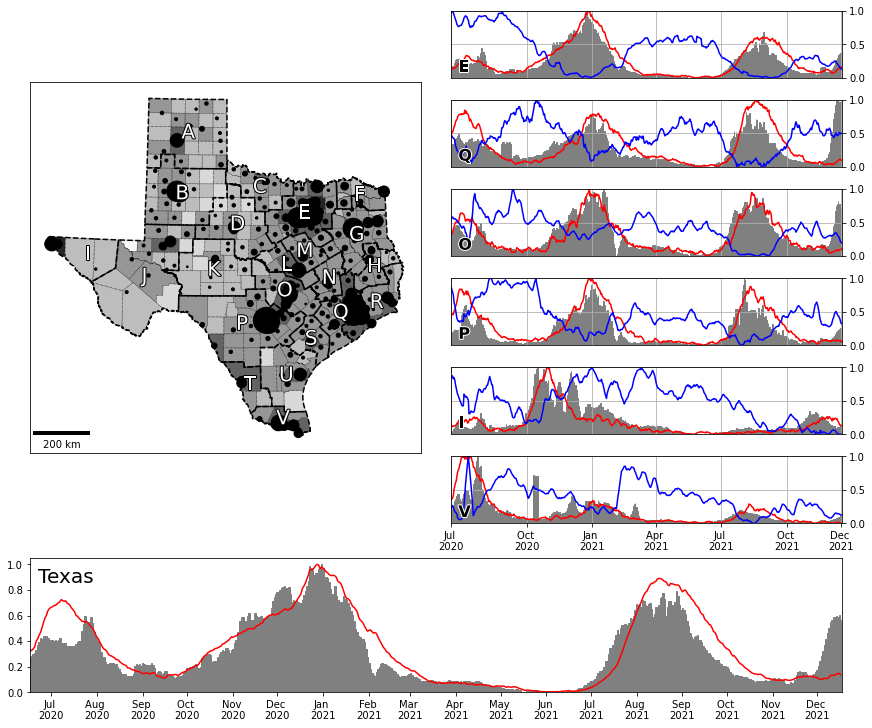

In [11]:
gs_kw = dict(width_ratios=[1, 1], height_ratios=[1, 1, 1, 1, 1, 1, 2])
fig, axd = plt.subplot_mosaic([['left', 'right_1'], 
                               ['left', 'right_2'], 
                               ['left', 'right_3'], 
                               ['left', 'right_4'],
                               ['left', 'right_5'],
                               ['left', 'right_6'],
                               ['bottom', 'bottom']
                              ],
                              gridspec_kw=gs_kw, 
                              figsize=(12, 10),
                              constrained_layout=True
                             )


### --------------- Plot Texas on the left handed side --------------- ###
# Define color maps
color_brewer = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']  # Hex color codes were grabbed from ColorBrewer
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=6)  # Create a colormap instance with the hex codes

# Hospitals: proportional symbol based on ICU beds 
hospitals['markersize'] = hospitals.apply(lambda x:x['ICU_Beds'] * 3 , axis=1)
hospitals.plot(markersize='markersize', ax=axd['left'], zorder=2, color='black', legend=True)

# Create Choropleth map of COVID-19 cases
map_class = [10**num for num in range(1, 7)]
daily_case_geom.plot('covid_case', 
                     ax=axd['left'], 
                     scheme='user_defined', # To use different (not predefined) bins, we need to call it as 'user_defined'
                     classification_kwds={'bins':map_class}, # then speicfy class here. 
                     k=7,
                     zorder=1, cmap=cm, legend=False)

# Decoration
county_geom.boundary.plot(color='black', 
                     linewidth=0.5, 
                     linestyle='dotted', 
                     ax=axd['left']
                    )

tsa_geom.boundary.plot(color='black', 
                       linewidth=1.5, 
                       linestyle='dashed', 
                       ax=axd['left'])

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    axd['left'].text(s=row['TSA'], # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
                     fontsize=20, 
                     color='white',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                     path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
                    )

axd['left'].get_xaxis().set_visible(False)  # Remove ticks and labels
axd['left'].get_yaxis().set_visible(False)
axd['left'].add_artist(ScaleBar(dx=1, location='lower left'))


### --------------- Plot COVID-trend per TSA on the right handed-side --------------- ###
period_index = []
plot_period = ['07/01/2020', '10/15/2020', '01/15/2021', '04/15/2021', '07/15/2021', '10/15/2021', '12/31/2021']
for val in plot_period:
    period_index.append(focus_date.index(val))

focus_tsa = ['E', 'Q', 'O', 'P', 'I', 'V']
for t_idx, t_tsa in enumerate(focus_tsa, start=1):
    axd[f'right_{t_idx}'].bar(ave_case_tsa.columns, normalize(ave_case_tsa.loc[t_tsa]), width=1.0, facecolor='grey', edgecolor='grey')
    
    normalize(ave_death_tsa.loc[t_tsa]).plot(ax=axd[f'right_{t_idx}'], color='red')
    normalize(icu_empty_ratio.loc[t_tsa]).plot(ax=axd[f'right_{t_idx}'], color='blue')
    
    
    axd[f'right_{t_idx}'].text(s=f'{t_tsa}', # String to be displayed; TSA name,
                               x=10, 
                               y=0.05, 
                               fontsize=16, 
                               ha='left', 
                               va='bottom', 
                               weight='bold',
                               path_effects=[pe.withStroke(linewidth=2, foreground="white")]
                              )

    axd[f'right_{t_idx}'].set_xlim(0, len(focus_date))
    axd[f'right_{t_idx}'].set_ylim(0, 1)
    axd[f'right_{t_idx}'].grid(which='both')
    axd[f'right_{t_idx}'].set_xticks(period_index)
    axd[f'right_{t_idx}'].set_yticks([0, 0.5, 1])
    axd[f'right_{t_idx}'].yaxis.tick_right()
    
    if t_idx < len(focus_tsa):
        axd[f'right_{t_idx}'].tick_params(axis='x', which='both', labelbottom=False, bottom=False)   
    else:
        axd[f'right_{t_idx}'].set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in plot_period])

### --------------- Plot COVID-19 trend for the entire state at bottom --------------- ###
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]

axd['bottom'].bar(trend.index, trend['case_norm'], width=1.0, facecolor='grey', edgecolor='grey')
axd['bottom'].plot(trend['death_norm'], color='red')
axd['bottom'].set_xlim(0, len(focus_date))

axd['bottom'].set_xticks([focus_date.index(val) for val in period])
axd['bottom'].set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period])
axd['bottom'].text(s='Texas', 
                   x= 5,
                   y= 0.9,
                   color='Black',
                   ha='left',
                   va='center',
                   fontsize=20
                  )

plt.show()


# 2. Spatiotemporal pattern of COVID-19 in Texas

## 2.1. COVID-19 positivity rate per county

In [12]:
ave_case_ratio_geom = ave_case_geom.copy(deep=True)

for date in focus_date:
    ave_case_ratio_geom[date] = ave_case_geom[date] / ave_case_geom['pop'] * 1000

ave_case_ratio_geom.head(3)

# Define classes for Choropleth map
ave_case_ratio_val = ave_case_ratio_geom[focus_date].values.reshape(-1)

map_class_case_ratio_val = mapclassify.NaturalBreaks(ave_case_ratio_val, k=7)
print(map_class_case_ratio_val.bins)
map_class_case_ratio_val

[0.11485609 0.28926363 0.53827346 0.92909172 1.67763582 4.08129925
 9.37543086]


NaturalBreaks       

  Interval     Count
--------------------
[0.00, 0.11] | 72464
(0.11, 0.29] | 35260
(0.29, 0.54] | 19395
(0.54, 0.93] |  9008
(0.93, 1.68] |  2659
(1.68, 4.08] |   611
(4.08, 9.38] |    49

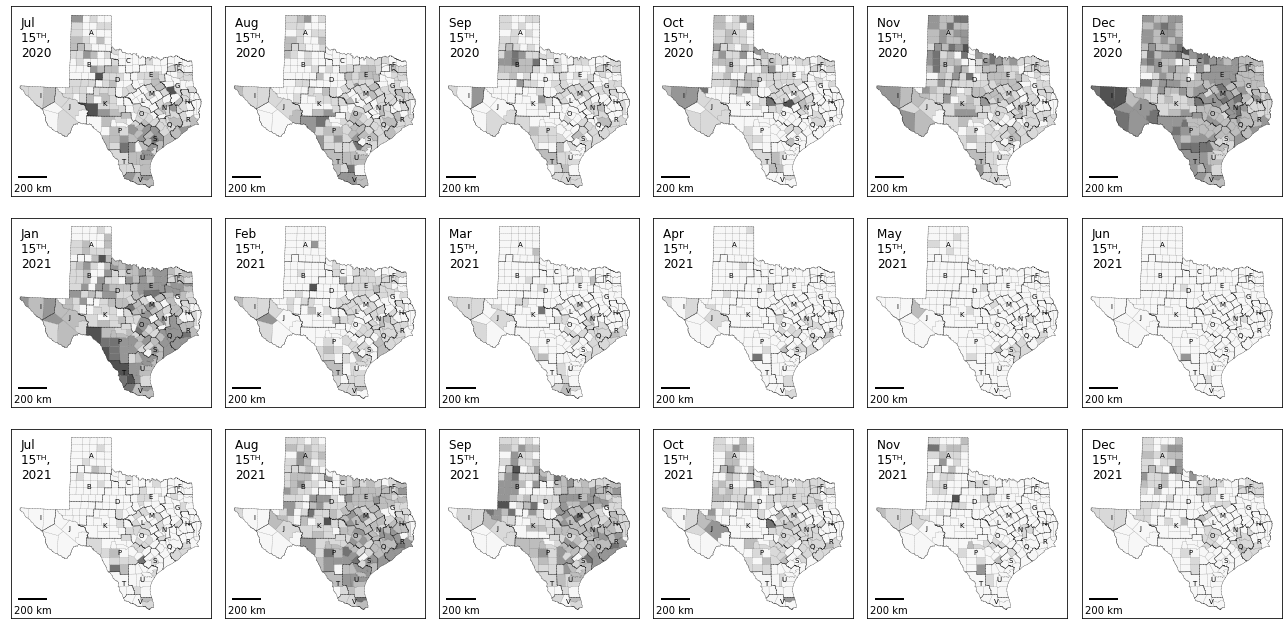

In [13]:
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]
# Define color map
color_brewer = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)
for idx, m in enumerate(period):
    ave_case_ratio_geom.plot(column=m, 
                             ax = ax[idx],
                             cmap=cm,
                             scheme='user_defined',
                             classification_kwds={'bins':map_class_case_ratio_val.bins} # then speicfy class here.
                            )
    tsa_geom.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_geom.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=row['TSA'], # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=7, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                    )
    
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n15ᵀᴴ, \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=12, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].add_artist(ScaleBar(dx=1, location='lower left'))
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

## 2.2. COVID-19 mortaltiy rate per county

In [14]:
ave_mortality_geom = ave_death_geom.copy(deep=True)

for date in focus_date:
    ave_mortality_geom[date] = ave_death_geom[date] / ave_death_geom['pop'] * 100000
    
ave_mortality_val = ave_mortality_geom[focus_date].values.reshape(-1)
map_class_mortality = mapclassify.NaturalBreaks(ave_mortality_val, k=7)
print(map_class_mortality.bins)
map_class_mortality

[ 0.48444497  1.52159112  3.06644997  5.4745025   8.86540541 16.00416108
 46.60918201]


NaturalBreaks         

   Interval      Count
----------------------
[ 0.00,  0.48] | 91432
( 0.48,  1.52] | 27430
( 1.52,  3.07] | 13078
( 3.07,  5.47] |  5363
( 5.47,  8.87] |  1482
( 8.87, 16.00] |   500
(16.00, 46.61] |   161

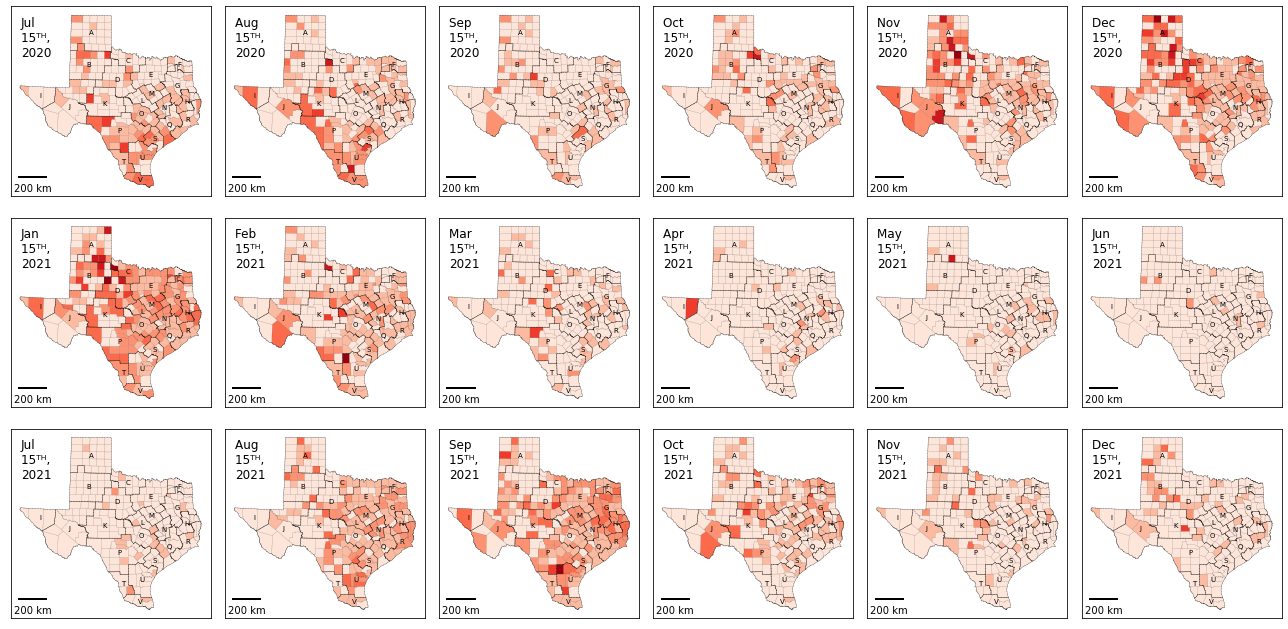

In [15]:
# Define color map
color_brewer = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)

for idx, m in enumerate(period):
    ave_mortality_geom.plot(column=m, 
                       ax = ax[idx],
                       cmap=cm,
                       scheme='user_defined',
                       classification_kwds={'bins':map_class_mortality.bins} # then speicfy class here.
                      )
    tsa_geom.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_geom.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=row['TSA'], # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=7, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                    )
    
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n15ᵀᴴ, \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=12, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].add_artist(ScaleBar(dx=1, location='lower left'))
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

# 3. Research workflow

Our study proceeds in three steps: 1) data preprocessing, 2) accessibility measurements, and 3) correlation analysis. 
1. Data preprocessing step aimed to populate temporal changes in supply (availability of ICU beds per hospital) and demand (accumulated COVID-19 cases per census tract). We also precomputed a travel time matrix between the hospitals (supply) and census tracts (demand) to facilitate further analysis. <br>
2. Accessibility measurements step utilized an E2SFCA method to assess spatial accessibility to healthcare resources during the COVID-19 pandemic under the interaction between the temporal changes of available ICU beds (supply) and the accumulated COVID-19 cases (demand).
3. Correlation analysis compared the daily accessibility and mortality rate of each county over time to see if their temporal changes are correlated. In detail, we employed Kendall’s tau correlation coefficients because the distributions of those two variables are not linear. The method considers the variables based on their ranks but keeps their pairs. 

<img src="./images/workflow.jpg">

# 4. Accessibility measurements

## 4.1. Input variables for E2SFCA method

### Supply

In [16]:
# Supply locations
s_loc = hospitals.copy(deep=True)
s_loc = s_loc.set_index('HC_ID')
s_loc = s_loc.fillna(0)
s_loc.head(3)

Type    Zip  County  Staffed_Beds  ICU_Beds  \
HC_ID                                                                          
H000   Short Term Acute Care Hospital  75001  Dallas          32.0         4   
H001   Short Term Acute Care Hospital  75006  Dallas           0.0         0   
H002   Short Term Acute Care Hospital  75039  Dallas          80.0         8   

        FIPS TSA        lat        lng                         geometry  \
HC_ID                                                                     
H000   48113   E  32.984766 -96.829405  POINT (1295826.606 1205448.145)   
H001   48113   E  32.986187 -96.898161  POINT (1289408.831 1205423.487)   
H002   48113   E  32.902051 -96.957361  POINT (1284142.861 1195958.149)   

       markersize  
HC_ID              
H000           12  
H001            0  
H002           24

In [17]:
# Temporal variation of supply (ICU bed availability per TSA)
s_val = pd.read_csv(os.path.join(data, 'access/input_files/ICU_beds_available_ratio.csv'))
s_val = s_val.rename(columns={'Unnamed: 0': 'TSA'})
s_val = s_val.set_index('TSA')
s_val = s_val[focus_date]
s_val.head(3)

07/01/2020  07/02/2020  07/03/2020  07/04/2020  07/05/2020  07/06/2020  \
TSA                                                                           
A      0.239601    0.251007    0.256439    0.256262    0.256783    0.261419   
B      0.165706    0.160652    0.154369    0.146077    0.144407    0.143339   
C      0.308108    0.300000    0.304348    0.304348    0.304075    0.309375   

     07/07/2020  07/08/2020  07/09/2020  07/10/2020  ...  12/22/2021  \
TSA                                                  ...               
A      0.264535    0.260488    0.256133    0.248269  ...    0.079110   
B      0.129958    0.119266    0.120789    0.120423  ...    0.090835   
C      0.316456    0.321543    0.336570    0.339683  ...    0.037975   

     12/23/2021  12/24/2021  12/25/2021  12/26/2021  12/27/2021  12/28/2021  \
TSA                                                                           
A      0.081352    0.086207    0.087331    0.091352    0.085749    0.081535   
B      0.082651    0.077176    0.069959    0.059701    0.047225    0.050654   
C      0.025478    0.037037    0.066265    0.063953    0.072222    0.064865   

     12/29/2021  12/30/2021  12/31/2021  
TSA                                      
A      0.080668    0.079602    0.066946  
B      0.048250    0.048152    0.044199  
C      0.074534    0.087591    0.073394  

[3 rows x 549 columns]

### Demand

In [18]:
# Demand location (census tract)
d_loc = gpd.read_file(os.path.join(data, 'reference_data', 'geographic_units', 'tract_reference.shp'))
d_loc = d_loc.set_index('GEOID')
d_loc = d_loc[['geometry']]
d_loc.head(3)

geometry
GEOID                                                         
48001950100  POLYGON ((1405776.557 1097438.688, 1405779.438...
48001950401  POLYGON ((1392461.585 1072740.298, 1392447.163...
48001950402  POLYGON ((1379516.856 1075774.243, 1379519.198...

In [19]:
# Demand daily variation (accumulated COVID-19 cases for 25 days)
# Recovery date from COVID-19 for worse symptom: 18.70±2.50
# https://onlinelibrary.wiley.com/doi/pdf/10.1111/joim.13063

d_val = pd.read_csv(os.path.join(data, 'access/input_files/estimated_covid_case.csv'))
d_val = d_val.set_index('GEOID')
d_val = d_val.drop(columns=['FIPS', 'CTID', 'Pop_Ratio', 'County_Pop'])
d_val.head(3)

Tract_Pop  06/01/2020  06/02/2020  06/03/2020  06/04/2020  \
GEOID                                                                    
48001950100       4844    2.293966    4.982675    4.635610    5.783138   
48001950401       4838    2.291125    4.976504    4.629868    5.775974   
48001950402       7511    3.556974    7.726027    7.187875    8.967206   

             06/05/2020  06/06/2020  06/07/2020  06/08/2020  06/09/2020  ...  \
GEOID                                                                    ...   
48001950100    6.322170    6.236702    6.101965    6.076912    6.327030  ...   
48001950401    6.314339    6.228977    6.094407    6.069384    6.319193  ...   
48001950402    9.803018    9.670494    9.461573    9.422726    9.810554  ...   

             12/22/2021  12/23/2021  12/24/2021  12/25/2021  12/26/2021  \
GEOID                                                                     
48001950100    3.192800    3.474424    3.429260    3.811351    3.861207   
48001950401    3.188845    3.470121    3.425013    3.806630    3.856424   
48001950402    4.950686    5.387366    5.317336    5.909797    5.987102   

             12/27/2021  12/28/2021  12/29/2021  12/30/2021  12/31/2021  
GEOID                                                                    
48001950100    4.249330    4.389346    5.296056    5.465651    5.656361  
48001950401    4.244067    4.383909    5.289496    5.458881    5.649355  
48001950402    6.588918    6.806024    8.211949    8.474918    8.770629  

[3 rows x 580 columns]

### Mobility

In [20]:
# Precomputed travel time matrix between supply and demand locations
mobility_df = pd.read_csv(os.path.join(data, 'access/input_files/Precalculated_OD_Matrix.csv'))
mobility_df.head(3)

HC_ID        GEOID  trvl_time
0  H000  48439121609  39.038224
1  H000  48251130208  52.587246
2  H000  48251131000  65.449505

## 4.2. Enhanced two-step floating catchment area (E2SFCA) method 
### Threshold travel time: 60 minutes
### Distance decay: Log-logistics distribution

In [21]:
# # Following cell was run on Keeling due to multiprocessing capability (see 'ICU_Accessibility_Measurements.py'). 
# # Keeling will save the file in 'data/access/ICU_access_measures/keeling'
# # `acc_step1_{date}.csv` is the step 1 of E2SFCA method on `date`
# # `acc_step2_{date}.csv` is the step 2 of E2SFCA method on `date`

# if __name__ == "__main__":
#     pool = mp.Pool(8)
#     pool.map(utils.measure_accessibility_unpacker,
#              zip(itertools.repeat(s_loc),
#                  itertools.repeat(d_loc),
#                  itertools.repeat(s_val),
#                  itertools.repeat(d_val),
#                  itertools.repeat(mobility_df),
#                  focus_date
#                 )
#              )
#     pool.close()

In [23]:
# acc = d_loc.copy(deep=True)

# for date in tqdm(focus_date):
#     date_ = date.replace('/', '_')
#     temp_result = pd.read_csv(os.path.join(data, 'access', 'ICU_access_measures', 'keeling', f'acc_step2_{date_}.csv'))
#     temp_result['GEOID'] = temp_result['GEOID'].astype(str)
#     temp_result = temp_result.set_index('GEOID')
#     acc = acc.merge(temp_result, left_index=True, right_index=True)
    
# acc.head(3)

## 4.3. Plot accessibility measures at census tract level

In [24]:
# Measured accessibility to ICU beds per census tract
access_tract = gpd.read_file(os.path.join(data, 'access/ICU_access_measures/ICU_access_tract.shp'))
tract = gpd.read_file(os.path.join(data, 'reference_data', 'geographic_units', 'tract_reference.shp'))
access_tract = access_tract.merge(tract[['TSA', 'GEOID', 'County', 'pop']], on='GEOID')
access_tract.sort_values(by='GEOID', inplace=True, ignore_index=True)
access_tract.head(3)

GEOID  06/01/2020  06/02/2020  06/03/2020  06/04/2020  06/05/2020  \
0  48001950100    0.636676    0.566900    0.565632    0.329403    0.260474   
1  48001950401    0.120838    0.073134    0.075418    0.049090    0.042740   
2  48001950402    0.085996    0.055994    0.057200    0.035914    0.030953   

   06/06/2020  06/07/2020  06/08/2020  06/09/2020  ...  12/26/2021  \
0    0.262326    0.260252    0.251541    0.208287  ...    0.027885   
1    0.043147    0.042879    0.041804    0.037944  ...    0.011066   
2    0.031189    0.030959    0.030123    0.027099  ...    0.006884   

   12/27/2021  12/28/2021  12/29/2021  12/30/2021  12/31/2021  \
0    0.024680    0.022385    0.019416    0.017932    0.016549   
1    0.009805    0.008983    0.007605    0.007031    0.006406   
2    0.006104    0.005574    0.004738    0.004376    0.004004   

                                            geometry  TSA    County   pop  
0  POLYGON ((1405776.557 1097438.688, 1405779.438...    G  Anderson  4844  
1  POLYGON ((1392461.585 1072740.298, 1392447.163...    G  Anderson  4838  
2  POLYGON ((1379516.856 1075774.243, 1379519.198...    G  Anderson  7511  

[3 rows x 584 columns]

In [25]:
# Define classes for Choropleth map
access_tract_val = access_tract[focus_date].values.reshape(-1)

# Accessibiltiy more than 1 is unnecessary
access_tract_val[access_tract_val>1] = 1 
map_class_acc_tract = mapclassify.NaturalBreaks(access_tract_val, k=7)
print(map_class_acc_tract.bins)
map_class_acc_tract

[0.02042188 0.05715638 0.12148285 0.23668582 0.43805338 0.74527549
 1.        ]


NaturalBreaks         

  Interval       Count
----------------------
[0.00, 0.02] | 1982517
(0.02, 0.06] |  607204
(0.06, 0.12] |  212210
(0.12, 0.24] |   58456
(0.24, 0.44] |   20258
(0.44, 0.75] |    6476
(0.75, 1.00] |    3364

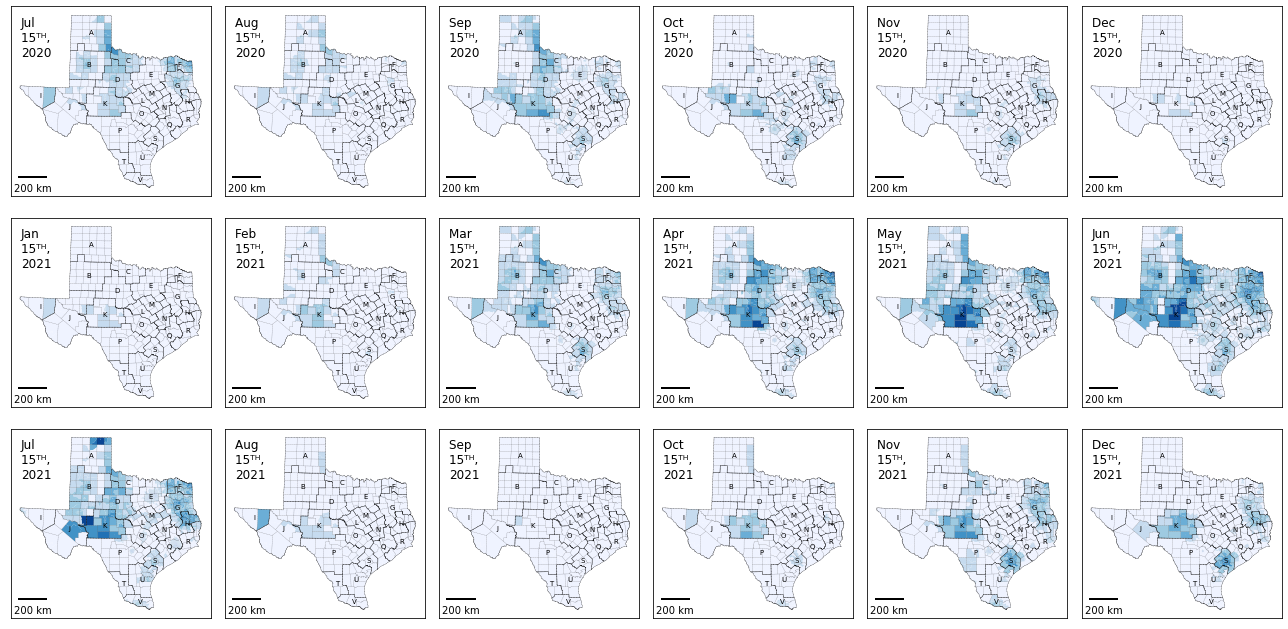

In [26]:
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]
# Define color map
color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)
for idx, m in enumerate(period):
    access_tract.plot(column=m, 
                      ax = ax[idx],
                      cmap=cm,
                      scheme='user_defined',
                      classification_kwds={'bins':map_class_acc_tract.bins} # then speicfy class here.
                     )
    tsa_geom.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_geom.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=row['TSA'], # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=7, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                    )
    
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n15ᵀᴴ, \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=12, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].add_artist(ScaleBar(dx=1, location='lower left'))
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

# 5. Correlation analysis (Kendall's tau)

## 5.1. Aggregate accessibility measures into county-level

In [27]:
access_county = county_geom.copy(deep=True)
access_county[focus_date] = 0.0
county_list = county_geom['County'].tolist()

for date in tqdm(focus_date):
    for temp_county in county_list:
        temp_pop_tract = access_tract.loc[access_tract['County'] == temp_county, 'pop']
        temp_access_tract = access_tract.loc[access_tract['County'] == temp_county, date]
        
        temp_access_county = sum(temp_pop_tract * temp_access_tract)
        temp_pop_county = access_county.loc[access_county['County'] == temp_county, 'pop'].values[0]
        
        access_county.loc[access_county['County'] == temp_county, date] = temp_access_county / temp_pop_county

access_county.head(3)

100%|██████████| 549/549 [05:50<00:00,  1.56it/s]


GEOID TSA    pop    County  \
0  48001   G  57810  Anderson   
1  48003   J  18036   Andrews   
2  48005   H  87322  Angelina   

                                            geometry  07/01/2020  07/02/2020  \
0  POLYGON ((1440392.625 1070275.995, 1440394.136...    0.043240    0.040854   
1  POLYGON ((792219.493 1130103.506, 792219.283 1...    0.075901    0.066010   
2  POLYGON ((1527772.708 998471.159, 1527771.700 ...    0.042250    0.034154   

   07/03/2020  07/04/2020  07/05/2020  ...  12/22/2021  12/23/2021  \
0    0.036800    0.036226    0.036697  ...    0.028047    0.027011   
1    0.056315    0.052505    0.052243  ...    0.015074    0.013627   
2    0.030142    0.029985    0.028442  ...    0.071102    0.062300   

   12/24/2021  12/25/2021  12/26/2021  12/27/2021  12/28/2021  12/29/2021  \
0    0.025422    0.022648    0.021609    0.019132    0.017454    0.014926   
1    0.012851    0.012995    0.013525    0.013756    0.014788    0.012687   
2    0.064983    0.073633    0.071739    0.063523    0.055961    0.047618   

   12/30/2021  12/31/2021  
0    0.013797    0.012647  
1    0.010186    0.009068  
2    0.043154    0.030354  

[3 rows x 554 columns]

In [28]:
# Define classes for Choropleth map
access_county_val = access_county[focus_date].values.reshape(-1)

# Accessibiltiy more than 1 is unnecessary
access_county_val[access_county_val>1] = 1 
map_class_acc_county = mapclassify.NaturalBreaks(access_county_val, k=7)
print(map_class_acc_county.bins)
map_class_acc_county

[0.02369366 0.06900713 0.13940517 0.2443814  0.42934825 0.75535298
 1.        ]


NaturalBreaks       

  Interval     Count
--------------------
[0.00, 0.02] | 99495
(0.02, 0.07] | 24178
(0.07, 0.14] |  9529
(0.14, 0.24] |  3784
(0.24, 0.43] |  1636
(0.43, 0.76] |   530
(0.76, 1.00] |   294

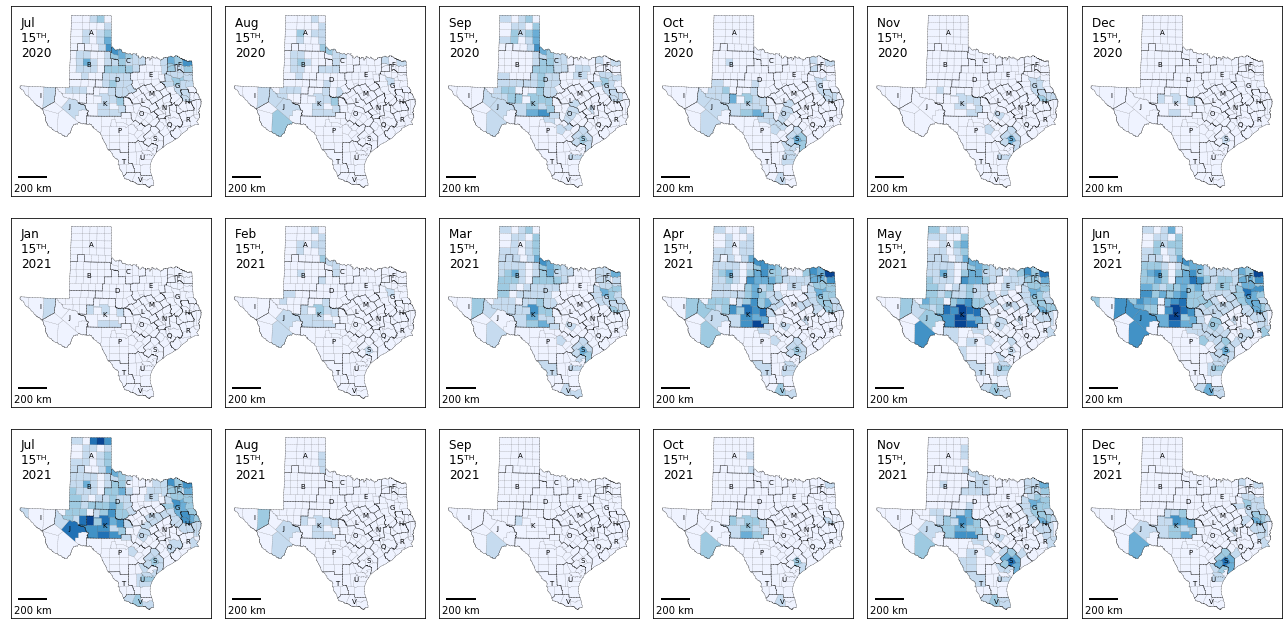

In [29]:
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]
# Define color map
color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)
for idx, m in enumerate(period):
    access_county.plot(column=m, 
                      ax = ax[idx],
                      cmap=cm,
                      scheme='user_defined',
                      classification_kwds={'bins':map_class_acc_county.bins} # then speicfy class here.
                     )
    tsa_geom.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_geom.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=row['TSA'], # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=7, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                    )
    
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n15ᵀᴴ, \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=12, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].add_artist(ScaleBar(dx=1, location='lower left'))
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

## 5.2. Correlation across space and time

In [30]:
corr_state = pd.DataFrame(list(product(county_list, focus_date)), columns=['County', 'Date'])

for idx, row in tqdm(corr_state.iterrows(), total=corr_state.shape[0]):
    corr_state.loc[idx, 'access'] = access_county.loc[access_county['County'] == row['County'], row['Date']].values[0]
    corr_state.loc[idx, 'mortality'] = ave_mortality_geom.loc[ave_mortality_geom['County'] == row['County'], row['Date']].values[0]

# Accessibiltiy more than 1 is unnecessary
corr_state['access'].mask(corr_state['access'] > 1, 1, inplace=True)

corr_state.head()

100%|██████████| 139446/139446 [06:11<00:00, 375.33it/s]


County        Date    access  mortality
0  Anderson  07/01/2020  0.043240   0.432451
1  Anderson  07/02/2020  0.040854   0.345961
2  Anderson  07/03/2020  0.036800   0.288301
3  Anderson  07/04/2020  0.036226   0.247115
4  Anderson  07/05/2020  0.036697   0.000000

KendalltauResult(correlation=-0.22561078885188915, pvalue=0.0)


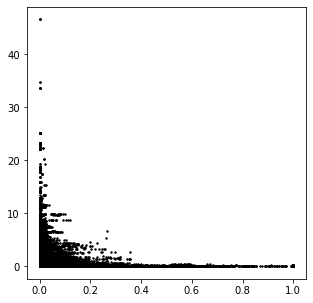

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

# Kendall's tau correlation at State Level
print(kendalltau(corr_state['access'], corr_state['mortality']))
ax.scatter(corr_state['access'], corr_state['mortality'],  color='black', s=2)

## 5.3. Correlation across time at county level

To investigate the spatiotemporal relationship between two variables, we increased the spatial or temporal granularity of correlation analysis as follows. First, we conducted a correlation analysis between ICU accessibility and mortality at the county level over the study period. This allowed us to explore which location provided a stronger negative correlation.

In [32]:
kendall_dict = dict()
no_access_county = list()

for idx, row in county_geom.iterrows():
    acc_ts = access_county.loc[access_county['County'] == row['County'], focus_date].values[0]
    
    if acc_ts.max() > 1:
        print(f"{row['County']}: Extraordinary Access")
        acc_ts[acc_ts > 1] = 1
    
    death_ts = ave_mortality_geom.loc[ave_mortality_geom['County'] == row['County'], focus_date].values[0]
    tau, taup = kendalltau(acc_ts, death_ts)
    
    kendall_dict[row['GEOID']] = dict()
    if tau is np.nan:
        kendall_dict[row['GEOID']]["coef"] = np.nan
        kendall_dict[row['GEOID']]["pval"] = np.nan
        kendall_dict[row['GEOID']]["notes"] = 'no access'
    
    else:
        
        if taup < 0.05:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'significant'
        
        else:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'not significant'

    
coefs = [kendall_dict[ind]["coef"] for ind in county_geom["GEOID"]]
pvals = [kendall_dict[ind]["pval"] for ind in county_geom["GEOID"]]
notes = [kendall_dict[ind]["notes"] for ind in county_geom["GEOID"]]

# Convert Dictionary to DataFrame
kendall_df = pd.DataFrame({"GEOID": county_geom["GEOID"], "coefs": coefs, "pvals": pvals, "notes": notes})
kendall_df['GEOID'] = kendall_df['GEOID'].astype(str)

kendall_df.head()

Bowie: Extraordinary Access
Brewster: Extraordinary Access
Childress: Extraordinary Access
Concho: Extraordinary Access
Culberson: Extraordinary Access
Kimble: Extraordinary Access
Lubbock: Extraordinary Access
Ochiltree: Extraordinary Access
Reagan: Extraordinary Access
Runnels: Extraordinary Access
Schleicher: Extraordinary Access
Sutton: Extraordinary Access
Tom Green: Extraordinary Access
Upton: Extraordinary Access
Webb: Extraordinary Access
Zapata: Extraordinary Access


GEOID     coefs          pvals        notes
0  48001 -0.460777   2.017236e-51  significant
1  48003 -0.483173   1.686527e-49  significant
2  48005 -0.672646  2.698667e-113  significant
3  48007 -0.452818   4.996913e-44  significant
4  48009 -0.381724   3.551005e-29  significant

In [33]:
kendall_gdf = county_geom.merge(kendall_df, on='GEOID')
kendall_gdf.head(3)

GEOID TSA    pop    County  \
0  48001   G  57810  Anderson   
1  48003   J  18036   Andrews   
2  48005   H  87322  Angelina   

                                            geometry     coefs          pvals  \
0  POLYGON ((1440392.625 1070275.995, 1440394.136... -0.460777   2.017236e-51   
1  POLYGON ((792219.493 1130103.506, 792219.283 1... -0.483173   1.686527e-49   
2  POLYGON ((1527772.708 998471.159, 1527771.700 ... -0.672646  2.698667e-113   

         notes  
0  significant  
1  significant  
2  significant

### Plot Correlation results

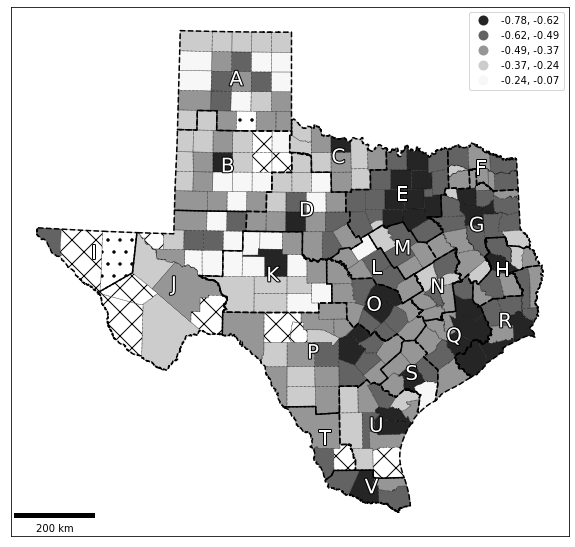

In [34]:
# Define color map
color_brewer = ['#f7f7f7','#cccccc','#969696','#636363','#252525']
color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=5)

fig, ax = plt.subplots(figsize=(10,10))

kendall_gdf.loc[kendall_gdf['notes'] == 'significant'].plot('coefs', ax=ax, scheme='fisher_jenks', cmap=cm, legend=True)
kendall_gdf.loc[kendall_gdf['notes'] == 'not significant'].plot(ax=ax, hatch='.', color='white')  # Locations with insignificant pearsonr correlation
kendall_gdf.loc[kendall_gdf['notes'] == 'no access'].plot(ax=ax, hatch='X', color='white')  # Locations without access to icu beds


county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

### Temporal changes in the six major counties

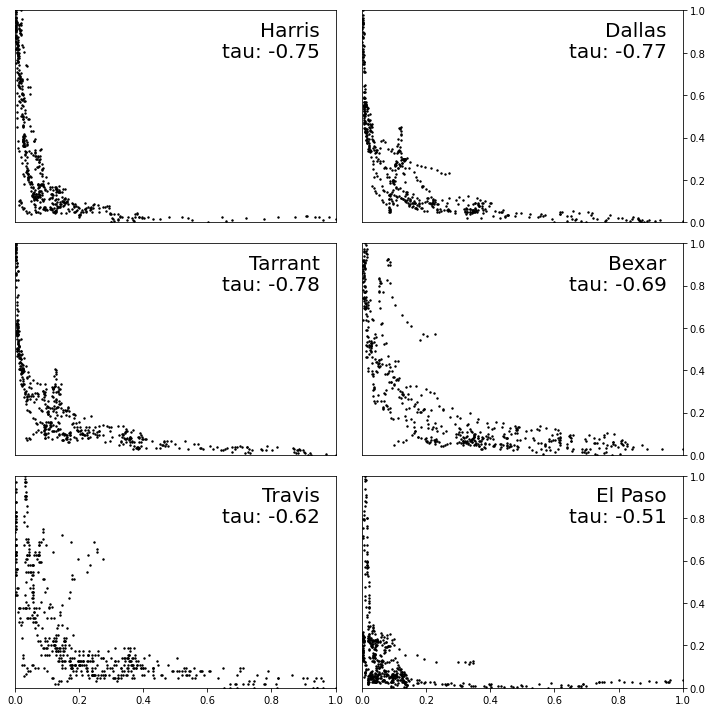

In [35]:
county_names = {'Harris': '48201', # Houston
                'Dallas': '48113', # Dallas
                'Tarrant': '48439', # Fort Worth
                'Bexar': '48029', # San Antonio
                'Travis': '48453', # Austin
                'El Paso': '48141'
               }

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes_ = axes.reshape(-1)

for idx, county_name in enumerate(county_names.keys()):  
    acc_ts = access_county.loc[access_county['County']==county_name, focus_date].values[0]
    
    if acc_ts.max() > 1:
        print(f"{row['County']}: Extraordinary Access")
        acc_ts[acc_ts > 1] = 1
        
    death_ts = ave_mortality_geom.loc[ave_mortality_geom['County']==county_name, focus_date].values[0]
    
    acc_ts = normalize(acc_ts)
    death_ts = normalize(death_ts)
    
    temp_tau = kendalltau(acc_ts, death_ts)
    
    axes_[idx].scatter(acc_ts, death_ts, color='black', s=2)
    axes_[idx].set_xlim(0, 1)
    axes_[idx].set_ylim(0, 1)
    
    axes_[idx].text(0.95, 0.95, county_name, fontsize=20, ha='right', va='top', transform=axes_[idx].transAxes)
    axes_[idx].text(0.95, 0.85, 
                    f'tau: {round(temp_tau[0], 2)}', 
                    fontsize=20, 
                    ha='right', 
                    va='top', 
                    transform=axes_[idx].transAxes, 
#                     path_effects=[pe.withStroke(linewidth=2, foreground="white")] # This will create boundary of text
           )
    
    
    axes_[idx].yaxis.tick_right()
    if idx %2 == 0:
        axes_[idx].get_yaxis().set_visible(False)
    if idx < 4 :
        axes_[idx].get_xaxis().set_visible(False)  # Remove ticks and labels
        
plt.tight_layout() # Will shrink empty area
plt.show()


## 5.4. Correlation across space at daily scale

Second, we analyzed the daily correlation between ICU bed accessibility and mortality for the entire study area to examine the temporal changes in correlation coefficients. We ran further correlation analyses for the period that provided a more substantial negative correlation.

In [36]:
tau_list = []
tau_pvals = []

for date in focus_date:
    acc_ts = access_county[date].to_list()
    death_ts = ave_mortality_geom[date].to_list()
    
    temp_tau = kendalltau(acc_ts, death_ts)
    
    if temp_tau[1] < 0.05:
        tau_list.append(temp_tau[0])
    else:
        tau_list.append(0)


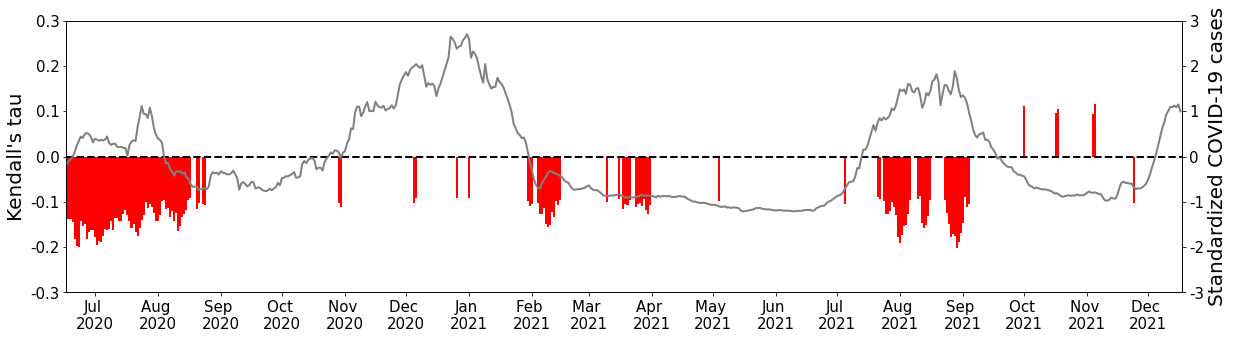

In [39]:
fig, ax = plt.subplots(figsize=(20, 5))

period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]

ax.bar(range(len(tau_list)), tau_list, width = 1, color='red', zorder=2, linewidth=1)
# ax.plot(range(len(tau_list)), tau_list, color='red', zorder=2)
ax.set_ylim(-0.3, 0.3)
ax.set_yticks([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3])
ax.set_yticklabels([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3], size=15)
ax.set_ylabel("Kendall's tau", fontsize=20)

ax2 = ax.twinx()
ax2.plot(trend.index, trend['case_stand'], color='grey', linewidth=2, zorder=1)
ax2.set_yticks([-3, -2, -1, 0, 1, 2, 3])
ax2.set_yticklabels([-3, -2, -1, 0, 1, 2, 3], size=15)
ax2.set_ylabel("Standardized COVID-19 cases", fontsize=20)
ax2.set_xlim(0, len(focus_date))
ax2.set_ylim(-3, 3)

ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

ax.set_xticks([focus_date.index(val) for val in period])
ax.set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period], size=15)

plt.show()

### Correlation for July, August 2020

In [40]:
focus_date_corr = [date for date in focus_date if (date[0:2] in ['07', '08']) & (date[6:10] == '2020')]

kendall_dict = dict()
no_access_county = list()

for idx, row in county_geom.iterrows():
    acc_ts = access_county.loc[access_county['County'] == row['County'], focus_date_corr].values[0]
    
    if acc_ts.max() > 1:
        print(f"{row['County']}: Extraordinary Access")
        acc_ts[acc_ts > 1] = 1
    
    death_ts = ave_mortality_geom.loc[ave_mortality_geom['County'] == row['County'], focus_date_corr].values[0]
    tau, taup = kendalltau(acc_ts, death_ts)
    
    kendall_dict[row['GEOID']] = dict()
    if taup is np.nan:
        kendall_dict[row['GEOID']]["coef"] = np.nan
        kendall_dict[row['GEOID']]["pval"] = np.nan
        kendall_dict[row['GEOID']]["notes"] = 'no access'
    
    else:
        
        if taup < 0.05:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'significant'
        
        else:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'not significant'

    
coefs = [kendall_dict[ind]["coef"] for ind in county_geom["GEOID"]]
pvals = [kendall_dict[ind]["pval"] for ind in county_geom["GEOID"]]
notes = [kendall_dict[ind]["notes"] for ind in county_geom["GEOID"]]

# Convert Dictionary to DataFrame
kendall_df = pd.DataFrame({"GEOID": county_geom["GEOID"], "coefs": coefs, "pvals": pvals, "notes": notes})
kendall_df['GEOID'] = kendall_df['GEOID'].astype(str)

kendall_df.head()

Childress: Extraordinary Access
Lubbock: Extraordinary Access


GEOID     coefs     pvals            notes
0  48001 -0.082185  0.376895  not significant
1  48003 -0.074537  0.457264  not significant
2  48005 -0.425315  0.000003      significant
3  48007 -0.060104  0.521201  not significant
4  48009 -0.247290  0.018945      significant

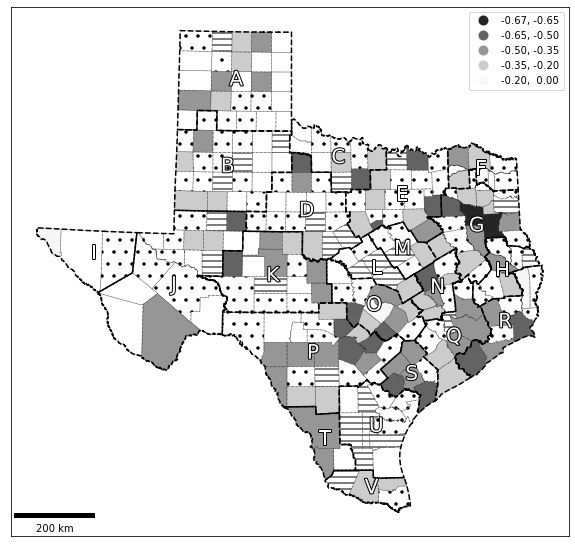

In [41]:
kendall_gdf = county_geom.merge(kendall_df, on='GEOID')
kendall_gdf.head(3)

# Define color map
color_brewer = ['#f7f7f7','#cccccc','#969696','#636363','#252525']
color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=5)

fig, ax = plt.subplots(figsize=(10,10))

temp_gdf = kendall_gdf.loc[(kendall_gdf['notes'] == 'significant') & (kendall_gdf['coefs'] < 0) & (kendall_gdf['coefs'].notnull())]
ud = mapclassify.UserDefined(temp_gdf['coefs'], [-0.65, -0.5, -0.35, -0.2, 0])
temp_gdf.plot('coefs', ax=ax, cmap=cm, 
              legend=True, 
              scheme='UserDefined', 
              classification_kwds={'bins': ud.bins})
kendall_gdf.loc[(kendall_gdf['notes'] == 'significant') & (kendall_gdf['coefs'] > 0)].plot(ax=ax, hatch='--', color='white')
kendall_gdf.loc[kendall_gdf['notes'] == 'not significant'].plot(ax=ax, hatch='.', color='white')  # Locations with insignificant kendall's tau correlation

county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

### Correlation for 2021 August, September

In [42]:
focus_date_corr = [date for date in focus_date if (date[0:2] in ['08', '09']) & (date[6:10] == '2021')]

kendall_dict = dict()
no_access_county = list()

for idx, row in county_geom.iterrows():
    acc_ts = access_county.loc[access_county['County'] == row['County'], focus_date_corr].values[0]
    
    if acc_ts.max() > 1:
        print(f"{row['County']}: Extraordinary Access")
        acc_ts[acc_ts > 1] = 1
    
    death_ts = ave_mortality_geom.loc[ave_mortality_geom['County'] == row['County'], focus_date_corr].values[0]
    tau, taup = kendalltau(acc_ts, death_ts)
    
    kendall_dict[row['GEOID']] = dict()
    if tau is np.nan:
        kendall_dict[row['GEOID']]["coef"] = np.nan
        kendall_dict[row['GEOID']]["pval"] = np.nan
        kendall_dict[row['GEOID']]["notes"] = 'no access'
    
    else:
        
        if taup < 0.05:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'significant'
        
        else:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'not significant'
    
coefs = [kendall_dict[ind]["coef"] for ind in county_geom["GEOID"]]
pvals = [kendall_dict[ind]["pval"] for ind in county_geom["GEOID"]]
notes = [kendall_dict[ind]["notes"] for ind in county_geom["GEOID"]]

# Convert Dictionary to DataFrame
kendall_df = pd.DataFrame({"GEOID": county_geom["GEOID"], "coefs": coefs, "pvals": pvals, "notes": notes})
kendall_df['GEOID'] = kendall_df['GEOID'].astype(str)

kendall_df.head()

Culberson: Extraordinary Access


GEOID     coefs         pvals            notes
0  48001 -0.663749  2.616803e-13      significant
1  48003 -0.463322  4.044349e-06      significant
2  48005  0.092921  3.028105e-01  not significant
3  48007 -0.258047  7.189499e-03      significant
4  48009  0.021698  8.382169e-01  not significant

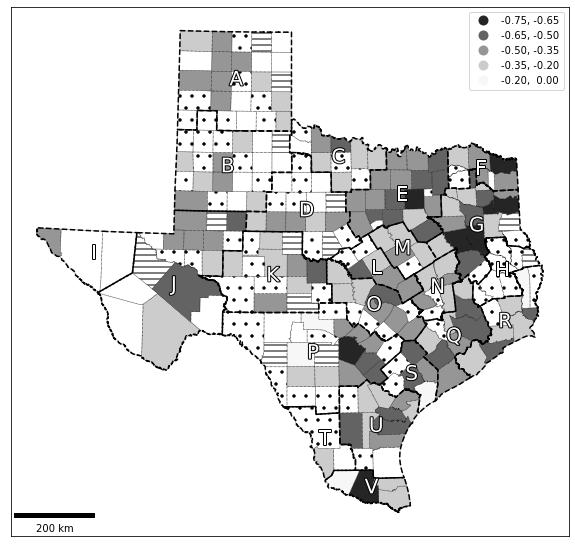

In [43]:
kendall_gdf = county_geom.merge(kendall_df, on='GEOID')
kendall_gdf.head(3)

# Define color map
color_brewer = ['#f7f7f7','#cccccc','#969696','#636363','#252525']
color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=5)

fig, ax = plt.subplots(figsize=(10,10))

temp_gdf = kendall_gdf.loc[(kendall_gdf['notes'] == 'significant') & (kendall_gdf['coefs'] < 0) & (kendall_gdf['coefs'].notnull())]
ud = mapclassify.UserDefined(temp_gdf['coefs'], [-0.65, -0.5, -0.35, -0.2, 0])
temp_gdf.plot('coefs', ax=ax, cmap=cm, 
              legend=True, 
              scheme='UserDefined', 
              classification_kwds={'bins': ud.bins})
kendall_gdf.loc[(kendall_gdf['notes'] == 'significant') & (kendall_gdf['coefs'] > 0)].plot(ax=ax, hatch='--', color='white')
kendall_gdf.loc[kendall_gdf['notes'] == 'not significant'].plot(ax=ax, hatch='.', color='white')  # Locations with insignificant kendall's tau correlation

county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

# 6. Appendix (Plot the trend per TSA)

### Calculate Accessbility at TSA level

In [44]:
access_tsa = tsa_geom.copy(deep=True)
access_tsa[focus_date] = 0.0
tsa_list = tsa_geom['TSA'].tolist()

for date in tqdm(focus_date):
    for temp_tsa in tsa_list:
        temp_pop_tract = access_tract.loc[access_tract['TSA'] == temp_tsa, 'pop']
        temp_access_tract = access_tract.loc[access_tract['TSA'] == temp_tsa, date]
        
        temp_access_tsa = sum(temp_pop_tract * temp_access_tract)
        temp_pop_tsa = access_tsa.loc[access_tsa['TSA'] == temp_tsa, 'pop'].values[0]
        
        access_tsa.loc[access_tsa['TSA'] == temp_tsa, date] = temp_access_tsa / temp_pop_tsa

access_tsa.head(3)

access_tsa = access_tsa.set_index('TSA')

100%|██████████| 549/549 [00:26<00:00, 20.81it/s]


In [45]:
# Define classes for Choropleth map
access_tsa_val = access_tsa[focus_date].values.reshape(-1)

# Accessibiltiy more than 1 is unnecessary
access_tsa_val[access_tsa_val>1] = 1 
map_class_acc_tsa = mapclassify.NaturalBreaks(access_tsa_val, k=7)
print(map_class_acc_tsa.bins)
map_class_acc_tsa

[0.02622004 0.07104915 0.13976832 0.23983409 0.403748   0.71697441
 1.        ]


NaturalBreaks       

  Interval     Count
--------------------
[0.00, 0.03] |  7624
(0.03, 0.07] |  2406
(0.07, 0.14] |  1190
(0.14, 0.24] |   445
(0.24, 0.40] |   250
(0.40, 0.72] |   105
(0.72, 1.00] |    58

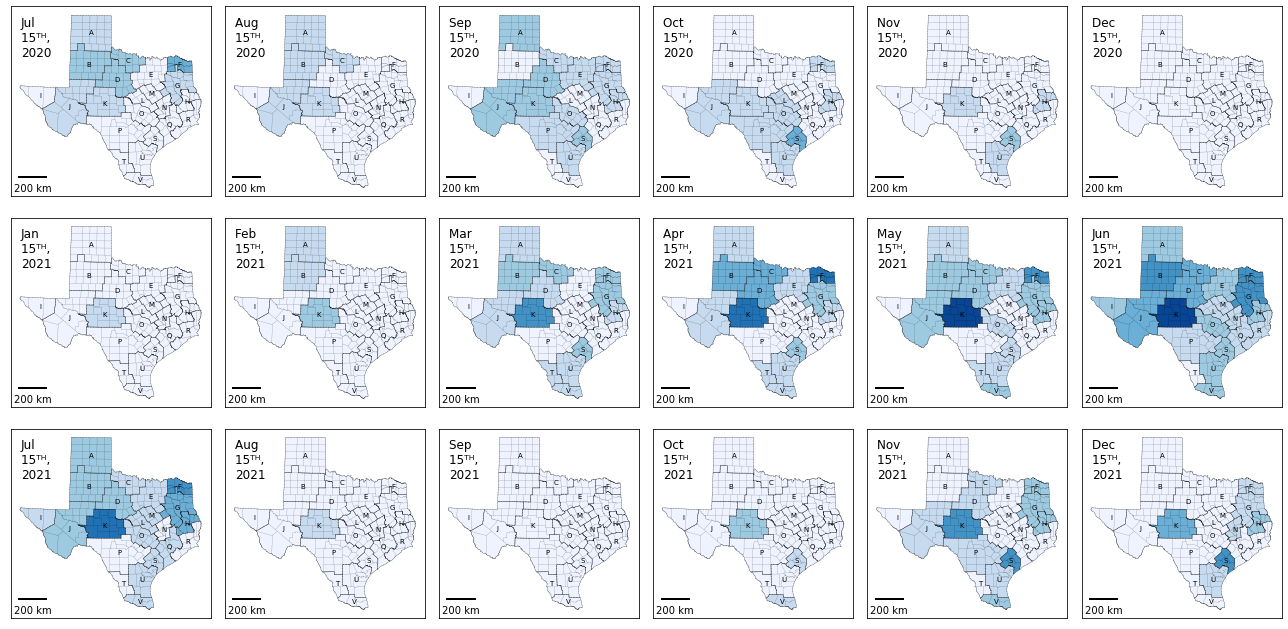

In [46]:
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]
# Define color map
color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)
for idx, m in enumerate(period):
    access_tsa.plot(column=m, 
                      ax = ax[idx],
                      cmap=cm,
                      scheme='user_defined',
                      classification_kwds={'bins':map_class_acc_tsa.bins} # then speicfy class here.
                     )
    tsa_geom.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_geom.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=row['TSA'], # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=7, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                    )
    
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n15ᵀᴴ, \n%Y')
    
    ax[idx].add_artist(ScaleBar(dx=1, location='lower left'))
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=12, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

### Correlation analysis at TSA level

In [47]:
kendall_tsa = tsa_geom.copy(deep=True)

for idx, row in kendall_tsa.iterrows():
    # Accessibility per TSA
    acc_ts = access_tsa.loc[access_tsa.index == row['TSA'], focus_date].values[0]
    acc_ts[acc_ts > 1] = 1
    
    # Death per TSA
    death_ts = ave_death_tsa.loc[ave_death_tsa.index == row['TSA'], focus_date].values[0]
        
    temp_tau = kendalltau(acc_ts, death_ts)
    kendall_tsa.at[idx, 'coefs'] = temp_tau[0]
    kendall_tsa.at[idx, 'pvals'] = temp_tau[1]
    
kendall_tsa.head(3)

TSA                                           geometry     pop     coefs  \
0   A  POLYGON ((889337.926 1348876.042, 889142.284 1...  428102 -0.722820   
1   B  POLYGON ((938332.252 1171851.846, 938332.217 1...  494388 -0.610851   
2   C  POLYGON ((1187193.612 1302823.305, 1187194.482...  218722 -0.659260   

           pvals  
0  1.555418e-139  
1  2.576771e-100  
2  1.696260e-114

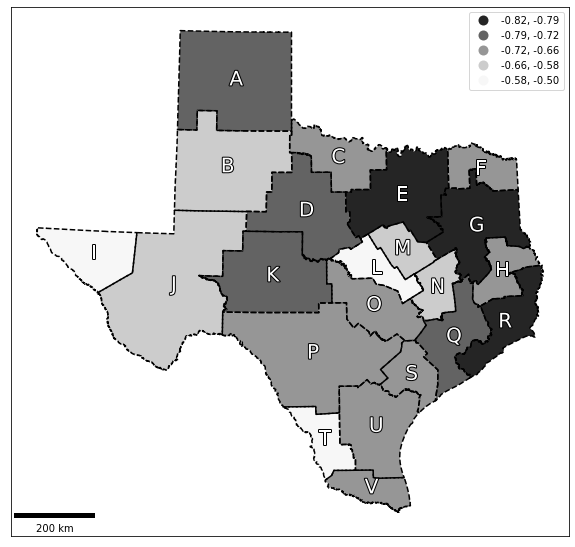

In [48]:
# Define color map
color_brewer = ['#f7f7f7','#cccccc','#969696','#636363','#252525']
color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=5)

fig, ax = plt.subplots(figsize=(10,10))

kendall_tsa.plot('coefs', ax=ax, scheme='fisher_jenks', cmap=cm, legend=True)

# county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

TSA: A, Acc corr: -0.72, ICU corr: -0.3
TSA: B, Acc corr: -0.61, ICU corr: -0.35
TSA: C, Acc corr: -0.66, ICU corr: -0.21
TSA: D, Acc corr: -0.76, ICU corr: -0.54
TSA: E, Acc corr: -0.82, ICU corr: -0.49
TSA: F, Acc corr: -0.69, ICU corr: -0.56
TSA: G, Acc corr: -0.79, ICU corr: -0.62
TSA: H, Acc corr: -0.7, ICU corr: -0.4
TSA: I, Acc corr: -0.52, ICU corr: 0.01
TSA: J, Acc corr: -0.63, ICU corr: -0.25
TSA: K, Acc corr: -0.73, ICU corr: -0.23
TSA: L, Acc corr: -0.53, ICU corr: -0.17
TSA: M, Acc corr: -0.58, ICU corr: -0.38
TSA: N, Acc corr: -0.62, ICU corr: -0.47
TSA: O, Acc corr: -0.69, ICU corr: -0.28
TSA: P, Acc corr: -0.69, ICU corr: -0.24
TSA: Q, Acc corr: -0.76, ICU corr: -0.59
TSA: R, Acc corr: -0.79, ICU corr: -0.52
TSA: S, Acc corr: -0.66, ICU corr: -0.34
TSA: T, Acc corr: -0.5, ICU corr: -0.12
TSA: U, Acc corr: -0.67, ICU corr: -0.25
TSA: V, Acc corr: -0.68, ICU corr: -0.06


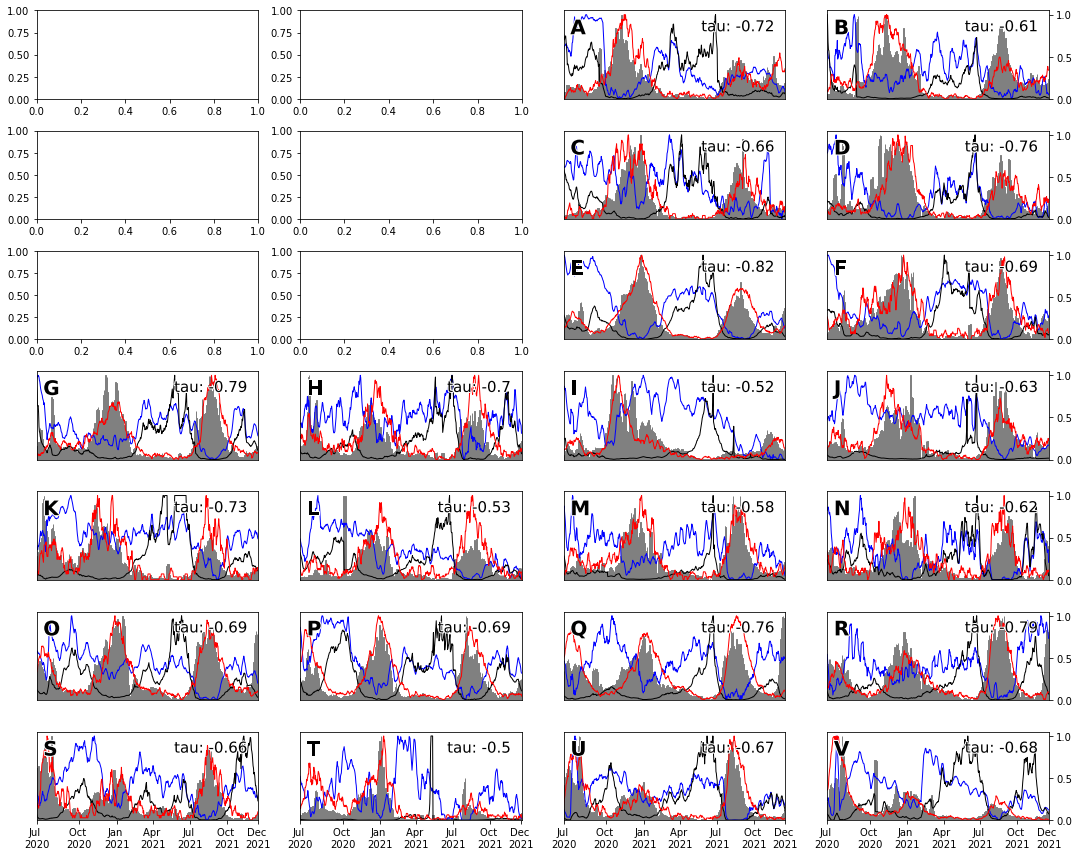

In [49]:
# Plot the trend per TSA
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]

plot_period = ['07/01/2020', '10/15/2020', '01/15/2021', '04/15/2021', '07/15/2021', '10/15/2021', '12/31/2021']

fig, axes = plt.subplots(7, 4, figsize=(15, 12))

for idx, t_tsa in enumerate(tsa_list, start=2):

    if (idx > 3) & (idx < 6):
        idx += 2
    elif (idx >= 6) :
        idx += 4
    
    ax = axes.reshape(-1)[idx]
    
    icu_ts = icu_empty_ratio.loc[icu_empty_ratio.index == t_tsa, focus_date].values[0]
    icu_ts = normalize(icu_ts)
    ax.plot(focus_date, icu_ts, label='ICU', color='blue', linewidth=1)
    
    acc_ts = access_tsa.loc[access_tsa.index == t_tsa, focus_date].values[0]
    acc_ts[acc_ts > 1] = 1
    acc_ts = normalize(acc_ts)
    ax.plot(focus_date, acc_ts, label='Access', color='black', linewidth=1)
    
    case_ts = ave_case_tsa.loc[ave_case_tsa.index == t_tsa, focus_date].values[0]
    case_ts = normalize(case_ts)
    ax.bar(focus_date, case_ts, label='Case', width=1.0, facecolor='grey', edgecolor='grey')
    
    death_ts = ave_death_tsa.loc[ave_death_tsa.index == t_tsa, focus_date].values[0]
    death_ts = normalize(death_ts)
    ax.plot(focus_date, death_ts, label='Death', color='red', linewidth=1)
    
    temp_tau = kendalltau(acc_ts, death_ts)
    print(f"TSA: {t_tsa}, Acc corr: {round(temp_tau[0], 2)}, ICU corr: {round(kendalltau(icu_ts, death_ts)[0], 2)}")
    
    ax.text(0.03, 
            0.9, 
            t_tsa, 
            fontsize=20, 
            ha='left', 
            va='top', 
            transform=ax.transAxes, 
            weight='bold',
            path_effects=[pe.withStroke(linewidth=2, foreground="white")] # This will create boundary of text
           )
    ax.text(0.95, 
            0.9, 
            f'tau: {round(temp_tau[0], 2)}', 
            fontsize=15, 
            ha='right', 
            va='top', 
            transform=ax.transAxes, 
            path_effects=[pe.withStroke(linewidth=2, foreground="white")] # This will create boundary of text
           )

    
    ax.set_xlim(0, len(focus_date))
    
    if idx < 28 - 4:
        ax.get_xaxis().set_visible(False)
        
    else:
        ax.set_xticks([focus_date.index(val) for val in plot_period]) # The locations that ticks will be displayed.
        ax.set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in plot_period])
        
        
    if idx % 4 != 3:
        ax.get_yaxis().set_visible(False)
       
    else:
        ax.set_yticks([0, 0.5, 1])
        ax.yaxis.tick_right()

plt.tight_layout()
plt.show()